In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.utils.tensorboard as tb
from Preprocessing.preprocessing import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [3]:
#static parameters
train_batch_size = 170
val_batch_size = 170
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [4]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [5]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [6]:
network_output.shape

torch.Size([8617])

In [7]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [8]:
network_input.shape

torch.Size([8617, 50, 1])

In [9]:
'''
data is highly unbalanced
# '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

'\ndata is highly unbalanced\n# '

In [10]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -117]
network_output = network_output[: -117]

print(network_input.shape)
print(network_output.shape)

torch.Size([8500, 50, 1])
torch.Size([8500])


In [11]:
#network_input[0]

In [12]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.5)
        
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, hidden,batch_size):
        
        output, hidden = self.lstm(x, hidden)        
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, self.hidden_size)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_().cuda(),
          weight.new(self.num_layers, batch_size, self.hidden_size).zero_().cuda())
        return hidden

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [13]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [14]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=38, bias=True)
)

In [15]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [24]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        h = tuple([each.data for each in hidden])
        

        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, h = model.forward(inputs, h,train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        #logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h = tuple([each.data for each in hidden])
        
        output, hidden = model.forward(inputs, val_h,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256_256_our_normalization_formula.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.2581464 	Val Loss:2.9775508 	Train Acc: 7.544118% 	Val Acc: 11.4117651%
Validation Loss decreased from    inf to 2.977551, saving the model weights
Epoch: 1	Train Loss: 3.1063758 	Val Loss:2.9724586 	Train Acc: 8.808824% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.977551 to 2.972459, saving the model weights
Epoch: 2	Train Loss: 3.0548235 	Val Loss:2.9512067 	Train Acc: 9.470588% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.972459 to 2.951207, saving the model weights
Epoch: 3	Train Loss: 3.0056863 	Val Loss:2.8510328 	Train Acc: 10.35294% 	Val Acc: 13.2352945%
Validation Loss decreased from 2.951207 to 2.851033, saving the model weights
Epoch: 4	Train Loss: 2.9115250 	Val Loss:2.7754004 	Train Acc: 11.57353% 	Val Acc: 13.0000004%
Validation Loss decreased from 2.851033 to 2.775400, saving the model weights
Epoch: 5	Train Loss: 2.8379992 	Val Loss:2.7353734 	Train Acc: 12.72059% 	Val Acc: 12.1176474%
Validation Loss decreased from 2.775400 to

Validation Loss decreased from 0.667816 to 0.638809, saving the model weights
Epoch: 118	Train Loss: 0.9387697 	Val Loss:0.8136419 	Train Acc: 70.60294% 	Val Acc: 75.5882353%
Epoch: 119	Train Loss: 0.9262842 	Val Loss:0.9804910 	Train Acc: 70.79412% 	Val Acc: 71.6470587%
Epoch: 120	Train Loss: 0.9478057 	Val Loss:0.8430493 	Train Acc: 70.36765% 	Val Acc: 74.9411774%
Epoch: 121	Train Loss: 0.9037269 	Val Loss:0.9063616 	Train Acc: 71.39706% 	Val Acc: 72.2941178%
Epoch: 122	Train Loss: 0.9240445 	Val Loss:0.8555459 	Train Acc: 71.30882% 	Val Acc: 74.7647059%
Epoch: 123	Train Loss: 0.9483112 	Val Loss:0.8641588 	Train Acc: 70.77941% 	Val Acc: 73.7647063%
Epoch: 124	Train Loss: 0.9206590 	Val Loss:0.8451085 	Train Acc: 70.77941% 	Val Acc: 74.7058827%
Epoch: 125	Train Loss: 0.8360820 	Val Loss:0.7896248 	Train Acc: 73.16177% 	Val Acc: 76.4705878%
Epoch: 126	Train Loss: 0.8026342 	Val Loss:0.5272998 	Train Acc: 74.51471% 	Val Acc: 85.9411758%
Validation Loss decreased from 0.638809 to 0.5273

Epoch: 260	Train Loss: 0.0814107 	Val Loss:0.0633034 	Train Acc: 97.86765% 	Val Acc: 97.9411757%
Epoch: 261	Train Loss: 0.1004882 	Val Loss:0.0732879 	Train Acc: 96.97059% 	Val Acc: 97.8235292%
Epoch: 262	Train Loss: 0.1155509 	Val Loss:0.0928915 	Train Acc: 96.39706% 	Val Acc: 96.9411743%
Epoch: 263	Train Loss: 0.1670619 	Val Loss:0.1359343 	Train Acc: 95.17647% 	Val Acc: 96.1764699%
Epoch: 264	Train Loss: 0.2143920 	Val Loss:0.1583338 	Train Acc: 93.42647% 	Val Acc: 95.0588226%
Epoch: 265	Train Loss: 0.2623661 	Val Loss:0.2368511 	Train Acc: 92.35294% 	Val Acc: 92.7058816%
Epoch: 266	Train Loss: 0.2460853 	Val Loss:0.1084158 	Train Acc: 92.44118% 	Val Acc: 96.6470587%
Epoch: 267	Train Loss: 0.2303385 	Val Loss:0.1061014 	Train Acc: 92.94118% 	Val Acc: 96.6470581%
Epoch: 268	Train Loss: 0.1585358 	Val Loss:0.0863132 	Train Acc: 95.16176% 	Val Acc: 97.3529410%
Epoch: 269	Train Loss: 0.1088349 	Val Loss:0.0596599 	Train Acc: 96.70588% 	Val Acc: 98.1176466%
Epoch: 270	Train Loss: 0.09528

Epoch: 422	Train Loss: 0.0584533 	Val Loss:0.0248054 	Train Acc: 98.30882% 	Val Acc: 99.3529403%
Epoch: 423	Train Loss: 0.0600928 	Val Loss:0.0364505 	Train Acc: 98.2647% 	Val Acc: 98.6470574%
Epoch: 424	Train Loss: 0.0628894 	Val Loss:0.0289501 	Train Acc: 98.04412% 	Val Acc: 99.1764700%
Epoch: 425	Train Loss: 0.0567934 	Val Loss:0.0314285 	Train Acc: 98.32353% 	Val Acc: 98.9999986%
Epoch: 426	Train Loss: 0.0471218 	Val Loss:0.0285319 	Train Acc: 98.75% 	Val Acc: 99.1764700%
Epoch: 427	Train Loss: 0.0478415 	Val Loss:0.0291088 	Train Acc: 98.63235% 	Val Acc: 99.1764694%
Epoch: 428	Train Loss: 0.0490006 	Val Loss:0.0287097 	Train Acc: 98.48529% 	Val Acc: 99.1176462%
Epoch: 429	Train Loss: 0.0445547 	Val Loss:0.0271526 	Train Acc: 98.70588% 	Val Acc: 99.2352933%
Epoch: 430	Train Loss: 0.0406305 	Val Loss:0.0263121 	Train Acc: 99.0% 	Val Acc: 99.1176456%
Epoch: 431	Train Loss: 0.0425855 	Val Loss:0.0296991 	Train Acc: 98.80882% 	Val Acc: 98.9999986%
Epoch: 432	Train Loss: 0.0397973 	Val 

#### Music Genaration


In [27]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256_256_our_normalization_formula.pt'))
test_model.cuda()
test_model.eval()

Stacked_LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=38, bias=True)
)

In [28]:
# #load population database
# #testing_data = np.ones(200)*0
# testing_data = list(range(50,90))
# testing_data.extend(testing_data[::-1])
# testing_data = np.asarray(testing_data)
# testing_data = testing_data.reshape(testing_data.shape[0],1)

# initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

In [36]:
#load population database
testing_data = np.ones(200)*1
# testing_data = list(range(50,90))
# testing_data.extend(testing_data[::-1])
# testing_data_rev = testing_data[::-1]
# testing_data_rev.extend(testing_data)
# testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [30]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)
#     list1[i]=(list1[i])/(89)


list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [39]:
testing_data_unnorm

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [48]:
int_to_note

{0: 50,
 1: 52,
 2: 53,
 3: 54,
 4: 55,
 5: 56,
 6: 57,
 7: 58,
 8: 59,
 9: 60,
 10: 61,
 11: 62,
 12: 63,
 13: 64,
 14: 65,
 15: 66,
 16: 67,
 17: 68,
 18: 69,
 19: 70,
 20: 71,
 21: 72,
 22: 73,
 23: 74,
 24: 75,
 25: 76,
 26: 77,
 27: 78,
 28: 79,
 29: 80,
 30: 81,
 31: 82,
 32: 83,
 33: 84,
 34: 85,
 35: 86,
 36: 88,
 37: 89}

In [46]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    test_hidden = test_model.hidden_init(test_batch_size)

    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
        
        test_output,_ = test_model.forward(test_slice, test_hidden, test_batch_size)
        print(test_output)
        top_p, top_class = test_output.topk(1,dim =1)
        print(top_p)
        print(top_class)
        print(int2note[top_class.item()])
#         test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        test_seq[0][sequence_length - 1 + i][0] = (int2note[top_class.item()] - min_midi_number)/(max_midi_number - min_midi_number)
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [47]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

tensor([[-5.3910, -3.0518, -2.3529, -4.3106, -3.0977, -3.9509, -3.7206, -3.9411,
         -3.6954, -7.6719, -1.4397, -3.6105, -3.9444, -8.6946, -5.7710, -3.1181,
         -5.5251, -4.7863, -2.8310, -6.6637, -4.3037,  5.5416,  3.1254, -0.2569,
         -8.0789, -0.0412,  3.5051,  0.9924, 10.9958,  1.1220,  4.7281, -0.7076,
          7.0208,  5.1415, -0.4913,  5.7272,  0.1050, -1.0975]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[10.9958]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[28]], device='cuda:0')
tensor([[-1.6755, -0.7077, -1.1780, -0.0796, -4.5207, -1.3775, -0.4298,  0.2194,
         -3.2681, -4.9164, -2.3663, -6.3151, -3.0285, -9.9530, -6.7779, -5.2897,
         -2.4221, -4.7705, -6.1670, -1.5615, -2.4391, -5.0023, -2.9753,  6.0620,
          0.4434,  6.6230,  1.7800, 12.6993,  4.1079, -0.6712,  7.1380,  1.6138,
          8.1547,  6.3010,  7.0034, -0.7452,  0.0598, -1.7965]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[12.6993]], device='cud

       grad_fn=<SliceBackward>)
tensor([[14.6927]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[32]], device='cuda:0')
tensor([[-1.0839, -0.1938,  1.8519,  2.7461, -2.8604, -1.8725,  1.0805, -0.1017,
          2.4150, -1.3814,  1.0917, -4.8165, -1.5527, -5.9151, -5.7082, -4.9445,
         -3.5440, -8.5814, -2.0735, -4.5571, -2.9468, -2.5424, -3.5824, -2.9567,
          0.6692, -1.4074,  0.7889,  1.0523,  6.1840,  4.3080,  6.3164,  0.1422,
          8.2798, 12.4931,  5.4484, 10.4404,  4.4320,  1.1271]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[12.4931]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[33]], device='cuda:0')
tensor([[ 0.2039,  0.7431,  1.4528,  2.8212, -4.0442, -0.2851,  0.7399,  1.1690,
          0.6645,  2.0259,  1.0373, -4.8833, -2.4756, -5.5532, -5.1377, -4.7620,
         -2.1356, -3.5986, -4.6016, -1.9104, -1.2353, -2.0756, -4.5983,  0.6865,
          0.3676, -4.4379, -1.0850,  4.5341,  3.0157,  1.0658,  8.1355,  2.5221,
          8.6052, 15

tensor([[12.0201]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[ 4.9742e-01,  1.2732e-01, -1.0913e-01,  2.7464e+00, -4.0353e+00,
         -1.1241e+00, -7.8362e-01,  2.7365e+00,  1.1614e+00, -1.1936e+00,
          1.8909e+00, -4.9714e+00,  6.9341e-01,  6.3760e-01, -6.4008e+00,
         -2.8204e+00, -1.3934e+00, -4.0149e+00, -3.0236e+00, -8.3649e-01,
         -4.3100e+00, -6.5905e+00, -3.9214e+00, -4.0983e+00, -9.2842e-01,
         -1.3062e+00,  6.7649e-03,  5.4686e+00,  7.6594e+00,  5.9092e+00,
          3.5678e+00,  3.8048e+00,  1.1869e+01,  5.7815e+00,  6.7440e+00,
          1.0248e+01,  1.6763e+00,  1.5640e+00]], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([[11.8692]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[32]], device='cuda:0')
tensor([[-2.5133, -1.9265, -0.9536, -2.1326, -4.4787, -1.3831, -0.4917, -1.1937,
         -2.7825, -1.0005, -0.1383, -2.4085, -4.0019, -4.0122, -4.4723, -6.0927,
         -1.9054, -3.8581, -0.6749,

       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[10.9169]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[32]], device='cuda:0')
tensor([[-3.2665, -1.3390, -2.3977, -1.7119, -3.3927, -2.1367, -0.9285, -1.3691,
         -3.5358,  0.7117,  0.1010, -3.9613, -4.7982, -0.9956, -3.5342, -4.9989,
         -0.4999, -3.7796, -3.0846, -3.4624, -0.6148, -2.6751, -4.2941, -1.1893,
         -2.2545, -3.0142, -1.1341, -1.0792,  6.8739,  0.4344,  7.0133,  0.7375,
          8.2059,  7.0769,  3.9979,  7.9391,  4.3632,  0.8920]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[8.2059]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[32]], device='cuda:0')
tensor([[-2.0744, -1.3237, -0.9700, -1.1713, -3.5070, -1.7645,  1.7785, -1.9315,
         -4.3273, -1.7744, -0.3944, -4.7856, -3.0037, -4.6330, -4.7047, -7.0963,
         -1.5401, -5.3969, -3.3291, -3.7373, -1.9125, -3.2869, -3.9611, -1.9519,
         -5.6481, -0.5220, -2.0468,  3.7122,  9.3786,  6.8060,  5.3096,  0.9911,
    

       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[9.5044]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[33]], device='cuda:0')
tensor([[-3.6169, -2.1342, -1.0136, -2.1624, -3.1542, -2.7267, -0.7098, -0.6363,
         -3.0519, -1.8100, -0.6989, -2.9824, -4.3953, -2.6584, -5.1653, -6.0586,
         -0.6954, -3.9936, -2.2366, -2.2686, -2.8279, -3.5591, -3.9171,  0.0282,
         -3.2792,  1.0231, -2.7447,  1.2633,  6.8979,  3.9498,  3.7115, -0.0191,
          9.8882,  5.8598,  5.3410,  7.7893,  2.9925,  4.1004]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[9.8882]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[32]], device='cuda:0')
tensor([[-3.1166, -1.3568, -1.1202, -1.1639, -2.4859, -1.5832,  0.9326, -0.6223,
         -3.4895, -1.0779, -0.4717, -4.2736, -4.5764, -5.3617, -4.9541, -7.1837,
          2.1361, -3.6389, -1.4612, -3.4819, -2.6747, -3.2866, -6.5158, -1.2211,
         -3.4543, -2.4404, -1.2037,  3.2477,  6.5905,  4.6314,  5.5924,  2.5527,
     

tensor([[10.8210]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[-4.5105, -1.9594, -1.2048, -2.8255, -1.6403, -3.9798, -0.6382, -1.2774,
         -4.1743, -0.5631,  0.1738, -2.8821, -3.9390, -2.4097, -2.5004, -1.6544,
         -2.9377, -3.5260, -3.0614, -3.9086, -3.2361, -0.8930, -2.7259, -3.4742,
         -4.4420, -0.0860, -0.1987,  2.9338,  5.3815,  4.8978,  2.9419, -0.0661,
          7.6659,  6.1058,  7.2956,  8.0927,  4.8095,  3.0339]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[8.0927]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[-3.8917, -1.2207, -0.2910, -1.7488, -1.5443, -3.3798, -0.5600, -0.5424,
         -3.8121, -0.5093,  0.7171, -2.7840, -3.4148, -2.7682, -2.3827, -3.0815,
         -2.9375, -4.0928, -3.7118, -3.7495, -3.8102, -2.1831, -4.3973, -1.7099,
         -3.5917,  0.3875, -1.7097,  3.7210,  5.1188,  4.1748,  5.4416, -1.1499,
          7.7746,  7.5062,  7.9580,  7.0695,  4.0773,

tensor([[11.2293]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[-4.4620, -1.7324, -1.6289, -2.6995, -1.2406, -3.9930, -0.8877, -1.2637,
         -4.5982, -0.7846,  0.1342, -3.0278, -4.5637, -1.2462, -2.1186, -2.0870,
         -2.0570, -2.9258, -2.9038, -3.7227, -2.1820, -1.4725, -3.8161, -2.1810,
         -2.5856, -0.1314, -0.2189,  2.8947,  3.4542,  3.0150,  4.4433, -1.1743,
          7.1023,  6.8862,  7.0323,  5.7221,  4.1278,  1.8180]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[7.1023]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[32]], device='cuda:0')
tensor([[-2.4495, -1.4567, -1.0579, -2.4555, -1.6335, -2.1859,  1.4121, -0.9317,
         -4.5895, -2.0872, -1.0970, -3.8119, -3.3302, -4.5158, -4.1318, -5.5479,
         -0.7501, -3.2786, -1.8425, -3.7957, -4.1123, -3.4249, -4.5226,  0.2470,
         -2.6875,  0.6965, -0.9545,  2.9962,  7.1121,  4.6534,  4.1887,  1.0920,
          7.8764,  5.9108,  4.8949,  8.1357,  4.2933,

       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[6.9832]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[34]], device='cuda:0')
tensor([[-3.4235, -0.8914, -0.1009, -2.0658, -1.3503, -2.9192,  0.1443, -0.0698,
         -4.0301, -1.2289,  0.4905, -3.3468, -2.8896, -3.0167, -3.9000, -3.3195,
         -2.4690, -3.4851, -2.6374, -4.0397, -3.7349, -2.7141, -3.3010, -1.7308,
         -2.7437,  0.5320, -1.3760,  3.0744,  5.7622,  5.5721,  3.2421, -0.3403,
          9.4291,  6.6748,  7.1143,  8.5619,  3.7076,  3.7428]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[9.4291]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[32]], device='cuda:0')
tensor([[-1.9610, -0.0731,  0.5429, -1.3539, -0.2905, -1.4728,  2.2763,  0.7379,
         -3.0857, -0.5342,  0.3265, -3.4460, -2.5572, -4.0095, -4.2210, -5.1667,
         -1.7142, -3.8617, -2.4440, -4.0083, -4.7241, -4.3814, -5.0910, -0.7515,
         -1.1735,  0.4640, -0.5773,  3.1403,  6.7925,  4.8316,  5.6665,  1.9137,
     

tensor([[8.5583]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[34]], device='cuda:0')
tensor([[-3.7505, -1.2605,  0.1367, -1.4694, -0.0649, -2.8474,  0.0294, -0.7834,
         -2.9089, -1.7231,  0.5732, -3.1274, -3.5063, -1.2295, -3.6646, -4.2216,
         -1.3283, -3.8550, -2.3640, -3.6638, -3.3076, -2.2658, -4.5617, -2.8068,
         -3.5638, -0.6725, -0.8966,  0.0520,  6.4080,  4.5688,  2.7950,  0.8523,
          8.2542,  6.6280,  6.8962, 11.2641,  5.8515,  4.5551]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[11.2641]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[-3.6914, -0.6639, -0.1687, -1.1177, -0.1505, -2.9467, -0.0533, -0.3124,
         -3.3091, -1.0712,  1.1486, -2.6895, -3.0059, -1.4890, -2.2528, -2.3713,
         -2.2424, -3.7105, -2.7719, -3.6048, -3.3334, -1.3703, -4.6916, -2.9721,
         -3.3364, -1.1212, -0.9227,  1.8455,  4.3507,  4.5330,  4.4383, -0.1127,
          7.9718,  8.0773,  8.5554,  8.0510,  5.9396,

       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[11.0592]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[-3.2163e+00, -8.5345e-02, -6.1988e-02, -9.3863e-01, -3.1290e-01,
         -2.7142e+00,  7.5016e-02, -2.6665e-03, -3.3736e+00, -6.4326e-01,
          1.2661e+00, -2.4709e+00, -2.9201e+00, -1.6809e+00, -2.1627e+00,
         -2.6335e+00, -2.5873e+00, -3.3478e+00, -3.1218e+00, -3.9639e+00,
         -3.3273e+00, -1.7965e+00, -3.9730e+00, -2.2342e+00, -2.1213e+00,
         -7.8244e-01, -7.8197e-01,  2.7095e+00,  3.6468e+00,  4.5258e+00,
          4.8263e+00,  5.8461e-02,  8.3412e+00,  8.3158e+00,  8.9858e+00,
          6.5162e+00,  5.5695e+00,  3.0789e+00]], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([[8.9858]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[34]], device='cuda:0')
tensor([[-2.9540, -0.2557,  0.6018, -1.0854,  0.3608, -2.1248,  0.4810, -0.0160,
         -2.6126, -1.0666,  0.5052, -1.9799, -3.4153, -1.1482, -3.95

tensor([[8.5589]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[-4.5882, -1.3880, -1.3418, -2.8587, -1.2500, -3.8945, -0.8116, -0.6642,
         -4.8284, -0.8255,  0.5501, -2.8414, -4.0918, -0.9035, -2.1369, -2.2624,
         -2.3146, -2.4919, -2.5614, -3.7860, -2.3928, -1.6161, -3.7701, -2.1461,
         -2.1588, -0.0435, -0.8140,  1.9143,  3.8373,  3.6152,  4.2445, -0.9795,
          7.4528,  6.0951,  7.6693,  6.8853,  4.0876,  2.7428]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[7.6693]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[34]], device='cuda:0')
tensor([[-2.9245, -0.3788,  0.0779, -1.7248, -0.6723, -2.4493,  1.0238, -0.1123,
         -3.9088, -0.7044,  0.3941, -2.8682, -2.5209, -2.7380, -3.9518, -4.0836,
         -1.9053, -3.5164, -2.1738, -4.1423, -4.2830, -2.9390, -4.0492, -1.8353,
         -2.6260,  0.1576, -1.4403,  2.2338,  6.2433,  5.2466,  4.2050,  1.2753,
          8.6749,  6.4615,  7.4928,  8.7923,  4.8518, 

tensor([[35]], device='cuda:0')
tensor([[-4.5013, -2.0063, -1.2744, -2.5853, -0.6326, -4.0050, -0.8962, -1.3922,
         -3.9868, -1.4550, -0.1360, -2.7113, -4.1909, -1.5327, -2.4193, -1.6319,
         -2.7779, -4.1994, -1.7079, -3.5139, -2.7051, -0.9461, -3.3471, -3.8813,
         -3.6448, -0.3192,  0.7003,  1.5058,  6.0442,  3.2433,  2.7368, -0.6261,
          7.5909,  4.9516,  5.6011,  8.5762,  3.6552,  2.4378]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[8.5762]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[-3.4818, -1.0764, -0.5115, -2.1130, -1.4691, -3.2472, -0.0321, -0.2611,
         -4.1505, -0.6981,  0.5604, -2.6070, -2.8208, -2.2701, -3.0477, -2.2139,
         -2.9381, -3.3564, -3.5430, -4.2801, -3.8230, -1.7484, -3.3048, -1.7471,
         -2.1678,  0.5067, -1.0557,  3.5190,  5.0794,  4.3688,  3.9959, -0.5774,
          8.6206,  6.6655,  7.7248,  6.5585,  3.3380,  2.8674]],
       device='cuda:0', grad_fn=<SliceBackward>)


       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[10.5755]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[-4.7090e+00, -2.0864e+00, -1.4655e+00, -2.2298e+00, -1.3987e-03,
         -3.8388e+00, -1.1372e+00, -1.4979e+00, -3.7704e+00, -1.5925e+00,
          3.5168e-01, -2.5403e+00, -4.0283e+00, -9.4919e-01, -1.7981e+00,
         -1.7951e+00, -2.2838e+00, -4.1049e+00, -1.4359e+00, -3.3085e+00,
         -2.4688e+00, -9.6323e-01, -4.1296e+00, -4.0548e+00, -3.2633e+00,
         -1.1469e+00,  8.5596e-01,  5.9006e-01,  4.7252e+00,  2.6927e+00,
          3.6604e+00, -1.2133e-02,  7.1912e+00,  5.9352e+00,  5.9339e+00,
          8.6961e+00,  5.2696e+00,  2.3550e+00]], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([[8.6961]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[-4.1339, -1.2964, -0.9251, -2.6273, -1.3265, -3.6266, -0.3973, -0.5246,
         -4.2270, -1.2530,  0.4832, -2.9253, -3.5144, -1.9473, -2.81

       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[10.3069]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[-3.8179, -1.1793,  0.2360, -0.6985,  1.1704, -3.1714, -0.4009, -0.6898,
         -2.6411, -1.0666,  0.8886, -1.6837, -2.9075, -0.8378, -2.5639, -2.8917,
         -2.9660, -4.9236, -1.4547, -3.5794, -3.3563, -1.9712, -3.8967, -4.4938,
         -3.5377, -1.3335,  0.0543, -1.0779,  6.4890,  4.1569,  2.9082,  0.5699,
          8.9022,  5.9889,  6.4740, 11.1160,  5.9052,  3.6790]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[11.1160]], device='cuda:0', grad_fn=<TopkBackward>)
tensor([[35]], device='cuda:0')
tensor([[-5.0143, -1.8197, -1.7967, -3.0678, -0.8250, -4.1423, -1.2118, -1.2342,
         -4.8212, -1.0181,  0.3469, -3.0169, -4.5847, -1.0341, -1.6697, -1.7059,
         -1.8997, -2.7059, -1.6885, -3.3700, -1.7077, -1.1382, -4.0302, -3.1579,
         -2.6516, -0.8490,  0.0481,  1.5804,  2.9927,  3.2032,  3.8462, -0.9803,
   

In [42]:
#predicted_notes_lst

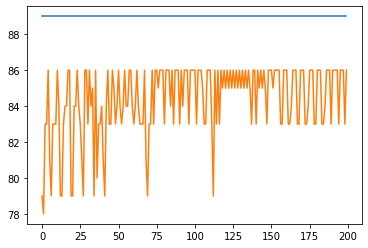

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(list(np.ones(200)*89))

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
# plt.plot(testing_data_unnorm)
plt.plot(predicted_notes_lst)

In [45]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({79: 11, 78: 1, 83: 49, 86: 94, 81: 4, 84: 22, 85: 18, 80: 1})